# One dimensional magnetic system

This notebook computes the one dimensional solution of a 1D magnetic system with uniform exchange, and Dzyaloshinskii-Moriya interactions. We use Ubermag to easily perform calculations with different finite-difference approximations of these exchange interactions, which include:

- 6 neighbors
- 12 neighbors
- 12 neighbors with Robin boundary conditions

Ubermag calls the corresponding exchange-interaction modules from OOMMF. At the end of this notebook we compare the solutions at the edges of the 1D sample. For the comparison we use GPU-optimized codes: Amumax and mumax+.

## Imports

In [1]:
import oommfc as oc
import discretisedfield as df
import micromagneticmodel as mm
import numpy as np
import scipy
import matplotlib.pyplot as plt
import scipy.interpolate

# from typing import NamedTuple
from collections import namedtuple

from pathlib import Path
import dill

import matplotlib
matplotlib.style.use('default')

In [2]:
# Specify OOMMF path
oc.runner.runner = oc.oommf.TclOOMMFRunner("/home/david/software/oommf/oommf.tcl")

Running OOMMF (TclOOMMFRunner)[2025/04/10 16:53]... (0.4 s)
OOMMF found and running.


## Calculation

We start by specifying the magnetic parameters, based on https://iopscience.iop.org/article/10.1088/1367-2630/aaea1c:

In [3]:
# Material parameters
A = 13e-12  # Jm^-1
D = 3e-3  # Jm^-2
M_s = 8.6e5  # Am^-1
K_u = 4e5  # Jm^-3

L = 50

In [4]:
# Use units in the nm scale
nm = 1e-9
delta = (np.sqrt(A / K_u)) / nm
xi = (2 * A / D) / nm

Below, we compute a semi-analytical solution of the system using the shooting method. Later we will use an analytical model, which produces similar results.

In [5]:
# Semi-analytic solution

# Set of differential equations for (u, v)
def ode_1d(theta, r, delta=1):
    return np.array([theta[1], np.cos(theta[0]) * np.sin(theta[0]) / delta ** 2])

# Define a function to solve the differential equation in the (0, l) range
# for any v(0) condition, u(0) is set to 1/xi
# The function returns the difference with respect to the desired solution at x=l
# The boundary conditions differ in sign for the interfacial and DMI cases
r_array = np.linspace(-L, L, 200)

def solve_ode(a, sign=1):  
    # Impose the condition over the angle rather than its derivative
    # solution, info = scipy.integrate.odeint(lambda t, r: ode_1d(t, r, delta=delta), 
    #                                         [np.arcsin(sign * delta / xi), a], r_array, full_output=True)
    solution = scipy.integrate.solve_ivp(lambda r, t: ode_1d(t, r, delta=delta),
                                         [-L, L],
                                         [np.arcsin(sign * delta / xi), a],
                                         t_eval=r_array,
                                         # full_output=True
                                         )
    # By inspection we found that the right extrema must be positive to match
    # the condition for the derivative
    return solution.y[0][-1] - np.arcsin(-sign * delta / xi)

# Find the root from the differences:
guess_int = scipy.optimize.brentq(lambda a: solve_ode(a, sign=-1), 0., 0.2)
# print('Interfacial: ', guess_int)

Now we define the number of discretization points we will use for the 1D mesh of the system to be solved. Using different resolutions for the mesh allows us to compare the error of the solutions.

In [6]:
# Define different values for n_x and oommf suffix to loop over
n_x_values = [20 + 2 * i for i in range(40)] + [100, 150, 200, 250, 400, 500]
suffix_values = ["6ngbrs", "12ngbrs", "12ngbrs_RobinBC"]

In [7]:
# Use a Python collection to store the data from the simulations
magData = namedtuple('magData', 'x mx my mz mz_interp mz_analytical theta_an_fun suffix n_x h')

Here we loop through the different mesh resolutions and also the different approximations for the exchange interactions. These approximations are specified in Ubermag using the **suffix** strings in the `suffix_values` list specified before. We finally save the data using the `magData` collection. To obtain the simulation solution exactly at the edges of the sample (because the cell centers do not lie exactly there), we extrapolate it using the simulation data. In this case, we only do this for the `m_z` component, and save it in the `mz_interp` attribute of the collection.

In [8]:
solutions = []

# Loop over different n_x and suffix values
for n_x in n_x_values:
    for suffix in suffix_values:
        mesh = df.Mesh(p1=(-50e-9, 0, 0), p2=(50e-9, 1e-9, 1e-9), n=(n_x, 1, 1))

        # Define the system
        system = mm.System(name=f"chain")
        system.m = df.Field(mesh, nvdim=3, value=[0, 0, 1], norm=M_s)
        system.energy = (
            mm.Exchange(A=A)
            + mm.UniaxialAnisotropy(K=K_u, u=[0, 0, 1])
            + mm.DMI(D=D, crystalclass="Cnv_z", suffix=suffix)
        )

        # Run the simulation
        mindriver = oc.MinDriver(stopping_mxHxm=0.1)
        mindriver.drive(system)

        x_nm = system.m.mesh.cells.x / nm

        # Obtain an analytical solution using the x coordinates
        # of the current data set (passed on the t_eval argument)
        # NOTE: If we use less or more points, the analytical sol should be the same
        #       We recompute here only to obtain the analytical sol array in the y[0] attribute
        solution_theory = scipy.integrate.solve_ivp(
            lambda r, t: ode_1d(t, r, delta=delta),
            [-L, L],
            [np.arcsin(-delta / xi), guess_int],
            t_eval=x_nm, dense_output=True)
        theta_an_sim = solution_theory.y[0]
        theta_an_fun = solution_theory.sol

        mz_interp = scipy.interpolate.interp1d(x_nm, system.m.orientation.z.array.squeeze(), 
                                               kind='cubic',
                                               bounds_error=False, fill_value='extrapolate')

        solutions.append(magData(x=x_nm,
                                 mx=system.m.orientation.x.array.squeeze(),
                                 my=system.m.orientation.y.array.squeeze(),
                                 mz=system.m.orientation.z.array.squeeze(),
                                 mz_interp=mz_interp,
                                 mz_analytical=np.cos(theta_an_sim),
                                 theta_an_fun=theta_an_fun,
                                 suffix=suffix,
                                 n_x=n_x,
                                 h=mesh.cell[0]
                                 )
                         )

Running OOMMF (TclOOMMFRunner)[2025/04/10 16:53]... (0.2 s)
Running OOMMF (TclOOMMFRunner)[2025/04/10 16:53]... (0.2 s)
Running OOMMF (TclOOMMFRunner)[2025/04/10 16:53]... (0.2 s)
Running OOMMF (TclOOMMFRunner)[2025/04/10 16:53]... (0.2 s)
Running OOMMF (TclOOMMFRunner)[2025/04/10 16:53]... (0.2 s)
Running OOMMF (TclOOMMFRunner)[2025/04/10 16:53]... (0.3 s)
Running OOMMF (TclOOMMFRunner)[2025/04/10 16:53]... (0.3 s)
Running OOMMF (TclOOMMFRunner)[2025/04/10 16:53]... (0.2 s)
Running OOMMF (TclOOMMFRunner)[2025/04/10 16:53]... (0.2 s)
Running OOMMF (TclOOMMFRunner)[2025/04/10 16:53]... (0.2 s)
Running OOMMF (TclOOMMFRunner)[2025/04/10 16:53]... (0.2 s)
Running OOMMF (TclOOMMFRunner)[2025/04/10 16:53]... (0.2 s)
Running OOMMF (TclOOMMFRunner)[2025/04/10 16:53]... (0.2 s)
Running OOMMF (TclOOMMFRunner)[2025/04/10 16:53]... (0.2 s)
Running OOMMF (TclOOMMFRunner)[2025/04/10 16:53]... (0.2 s)
Running OOMMF (TclOOMMFRunner)[2025/04/10 16:53]... (0.2 s)
Running OOMMF (TclOOMMFRunner)[2025/04/1

## Semi-analytical error comparison

We show the solution for a mesh resolution of `n_x = 100` points, and compute the error, using the semi-analytical solution:

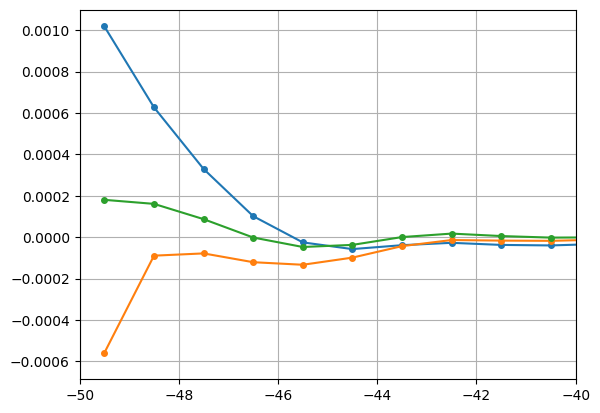

In [9]:
f, ax = plt.subplots()
for data in [s for s in solutions if s.n_x == 100]:
    ax.plot(data.x, 
            data.mz - data.mz_analytical, #  - np.cos(data.fitFunc(data.x / nm)),
            "o-",
            alpha=1., ms=4,
            label=f"OOMMF $m_x$ (n={data.n_x}, h={data.h/1e-9:.2g} nm, suffix={data.suffix})")

ax.set_xlim(-L, -L / 1.25)

plt.grid()

Here we show the error using all the Ubermag simulation data. We use the extrapolated data from the solution and compute the error at the sample edge, as a function of the mesh resolution `h = n_x / L`, with `L` as the sample length.

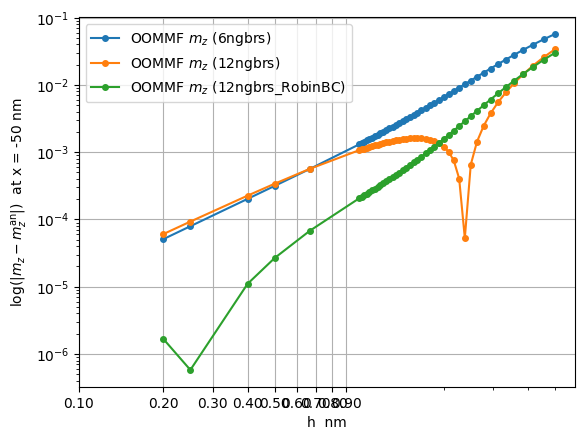

In [10]:
f, ax = plt.subplots()

for s in suffix_values:
    sdata = [sol for sol in solutions if sol.suffix==s]
    sdata = sorted(sdata, key=lambda x: x.n_x)
    # print(sdata)
    # print(sdata.sort(key=lambda x: x.n_x))
    mzerr = [np.abs(d.mz_interp(-L) - np.cos(d.theta_an_fun(-L)[0])) for d in sdata]
    hs = np.array([d.h for d in sdata])
    ax.plot(hs / nm, mzerr,
            "o-",
            alpha=1., ms=4,
            label=f"OOMMF $m_z$ ({s})")

ax.legend()
ax.set_xlabel('h  nm')
ax.set_ylabel(r'log($|m_z - m_z^{\mathrm{an}}|$)  at x = -50 nm')
ax.set_yscale('log')
ax.set_xscale('log')
xts = [0.10 * i for i in range(1, 10)]
ax.set_xticks([x for x in xts])
ax.set_xticklabels(['{:.2f}'.format(h) for h in xts])
# ax.set_xticks([1., 4.])
plt.grid()

6ngbrs [-2.24769992  3.78677816]
12ngbrs [-1.47665646 -0.37787599]
12ngbrs_RobinBC [-3.23066504  6.25271514]


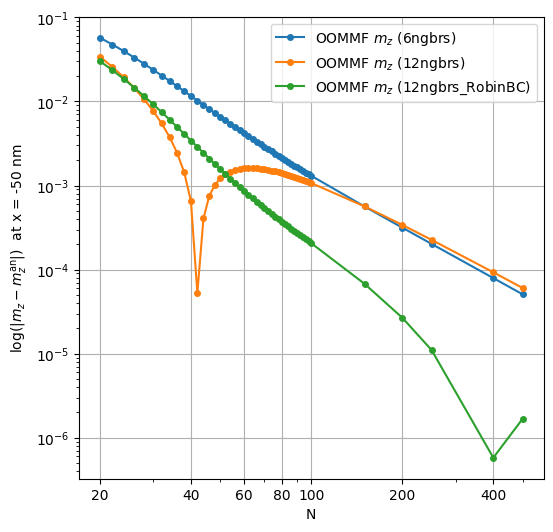

In [11]:
f, ax = plt.subplots(figsize=(6, 6))

for s in suffix_values:
    sdata = [sol for sol in solutions if sol.suffix==s]
    sdata = sorted(sdata, key=lambda x: x.n_x)
    # print(sdata)
    # print(sdata.sort(key=lambda x: x.n_x))
    mzerr = [np.abs(d.mz_interp(-L) - np.cos(d.theta_an_fun(-L)[0])) for d in sdata]
    ns = np.array([d.n_x for d in sdata])
    z = np.polyfit(np.log(ns), np.log(mzerr), 1)
    print(s, z)
    ax.plot(ns, mzerr,
            "o-",
            alpha=1., ms=4,
            label=f"OOMMF $m_z$ ({s})")

ax.legend()
ax.set_xlabel('N')
ax.set_ylabel(r'log($|m_z - m_z^{\mathrm{an}}|$)  at x = -50 nm')
ax.set_yscale('log')
ax.set_xscale('log')
xts = [20 * i for i in range(1, 6)] + [200, 400]
ax.set_xticks([x for x in xts])
ax.set_xticklabels(['{:.0f}'.format(x) for x in xts])
# ax.set_xticks([1., 4.])
plt.grid()

plt.savefig('N_vs_err-mz_OOMMF_stencils_TEST.pdf', bbox_inches='tight')

## AmuMax Data

In this section we extract the data from Amumax simulations. These simulations use the MuMax3 approximation of the exchange interactions.

In [12]:
AMX_DIR = Path('amumax_sim/amumax_1dchain_neumann_data/')

In [13]:
amx_data = {}
amx_interp_data = {}

for PKL in AMX_DIR.glob('*.pkl'):
    with open(PKL, 'rb') as FILE:
        data = dill.load(FILE)
    
    amx_data[data.n_x] = data

    mz_interp = scipy.interpolate.interp1d(data.x, data.mz, kind='cubic',
                                           bounds_error=False, fill_value='extrapolate')
    amx_interp_data[data.n_x] = mz_interp

Use the semi-analytical solution calculated for the `xev` array of points, so we can compute the errors at the edge:

In [14]:
xev = np.linspace(-L, L, 200)
solution_theory = scipy.integrate.solve_ivp(
            lambda r, t: ode_1d(t, r, delta=delta),
            [-L, L],
            [np.arcsin(-delta / xi), guess_int],
            t_eval=xev, dense_output=True)
theta_an_fun = solution_theory.sol

Here we compute the errors of the simulation:

In [15]:
L = 50
amx_n_vs_error = []
for k in sorted(amx_interp_data.keys()):
    intFun = amx_interp_data[k]
    
    mzerr = np.abs(intFun(-L) - np.cos(theta_an_fun(-L)[0]))
    amx_n_vs_error.append([k, mzerr])

amx_n_vs_error = np.array(amx_n_vs_error)

And plot the solution:

6ngbrs [-2.24769992  3.78677816]
12ngbrs [-1.47665646 -0.37787599]
12ngbrs_RobinBC [-3.23066504  6.25271514]


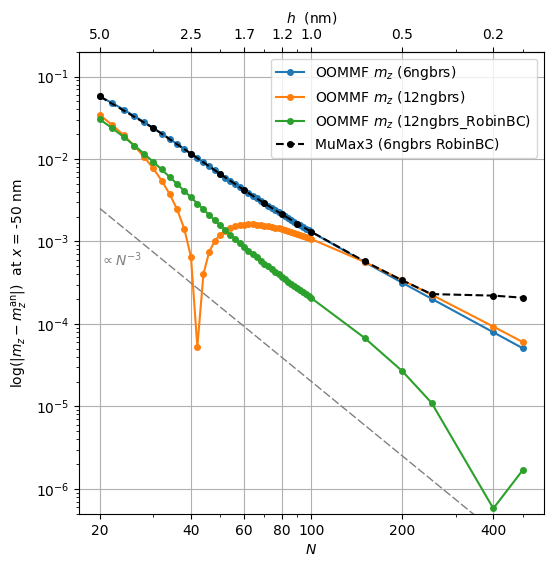

In [16]:
f, ax = plt.subplots(figsize=(6, 6))

for s in suffix_values:
    sdata = [sol for sol in solutions if sol.suffix==s]
    sdata = sorted(sdata, key=lambda x: x.n_x)
    # print(sdata)
    # print(sdata.sort(key=lambda x: x.n_x))
    mzerr = [np.abs(d.mz_interp(-L) - np.cos(d.theta_an_fun(-L)[0])) for d in sdata]
    ns = np.array([d.n_x for d in sdata])
    z = np.polyfit(np.log(ns), np.log(mzerr), 1)
    print(s, z)
    ax.plot(ns, mzerr,
            "o-",
            alpha=1.0, ms=4,
            label=f"OOMMF $m_z$ ({s})")

ax.plot(amx_n_vs_error[:, 0], amx_n_vs_error[:, 1], '--ok', label='MuMax3 (6ngbrs RobinBC)', ms=4)

# Scaling reference line
# xN2 = np.linspace(20, 400, 200)
# ax.plot(xN2, xN2**-2)

xN3 = np.linspace(20, 500, 200)
ax.plot(xN3, np.exp(3) * xN3**-3, '--', color='grey', lw=1, dashes=[6, 2])

ax.legend()
ax.set_xlabel(r'$N$')
ax.set_ylabel(r'log($|m_z - m_z^{\mathrm{an}}|$)  at $x$ = -50 nm')
ax.set_yscale('log')
ax.set_xscale('log')
xts = [20 * i for i in range(1, 6)] + [200, 400]  # n values
ax.set_xticks([x for x in xts])
ax.set_xticklabels(['{:.0f}'.format(x) for x in xts])
ax.set_ylim(0.5e-6, 0.2)

ax.text(20, 0.5e-3, '$\propto N^{-3}$', color ='grey')

hs = [100 / n for n in xts]
ax2 = ax.secondary_xaxis('top')
ax2.set_xticks([x for x in xts])
ax2.set_xticklabels(['{:.1f}'.format(h) for h in hs])
ax2.set_xlabel(r'$h$  (nm)')

plt.grid()

plt.savefig('N_vs_err-mz_OOMMF_stencils_TEST.pdf', bbox_inches='tight')

## MuMax Plus data

Here we analyze mumax+ data saved in `npz` Numpy files, which contain the mesh and magnetization data.

In [17]:
import re

In [18]:
MMP_DIR = Path('mumax_plus/branch_DMI-stdp/')

In [19]:
mmp_data = {}
mmp_interp_data = {}

mmp_sims_output = np.load(MMP_DIR / 'mumaxPlus_1dsystem_openbc_TRUE.npz')
mmp_sims_x = np.load(MMP_DIR / 'mumaxPlus_1dsystem_msh_openbc_TRUE.npz')

In [20]:
mmp_data = {}
mmp_interp_data = {}

# mmp_sims_output = np.load(MMP_DIR / 'mumaxPlus_1dsystem_openbc_TRUE.npz')
# mmp_sims_x = np.load(MMP_DIR / 'mumaxPlus_1dsystem_msh_openbc_TRUE.npz')

mmp_sims_output = np.load(MMP_DIR / 'mumaxPlus_1dsystem_openbc_FALSE_pbc_010.npz')
mmp_sims_x = np.load(MMP_DIR / 'mumaxPlus_1dsystem_msh_openbc_FALSE_pbc_010.npz')

for KEY in mmp_sims_output:
    
    data = mmp_sims_output[KEY]
    dx = mmp_sims_x[KEY] - mmp_sims_x[KEY]
    data_x = mmp_sims_x[KEY][0, 0, 0]
    data_x_nm = mmp_sims_x[KEY][0, 0, 0] * 1e9
    dx_nm = data_x_nm[1] - data_x_nm[0]

    n = int(re.search(r'(?<=nx)\d+', KEY).group(0))
    mmp_data[n] = data

    # Interpolate mz:
    mz_interp = scipy.interpolate.interp1d(data_x_nm - 50. + dx_nm * 0.5, 
                                           data[2, 0, 0], kind='cubic',
                                           bounds_error=False, fill_value='extrapolate')
    mmp_interp_data[n] = mz_interp

## Muller et al. model: kink-soliton-solution

Here we compute the error using the analytical model for the 1D system, where we have a kink-soliton solution from the Sine-Gordon differential equation after energy minimization of the functional of the 1D system, as in https://iopscience.iop.org/article/10.1088/1367-2630/18/6/065006. We apply the solution at the edge of the sample:

In [21]:
# plt.rcParams.update({
#     "text.usetex": False,
#     "font.family": "sans-serif",
#     "font.serif": ['Computer Modern'],
#     "font.size": 14
# })

In [22]:
A = 13e-12
D = 3e-3
Ku = 0.4e6

Q = D / (2 * A)
kappa = Ku / (A * (Q**2))

def y0_constant(kappa, h=0):
    hk = 1. / np.sqrt(h + kappa)
    y0 = -hk * np.arccosh((h + kappa + np.sqrt((h + kappa)**2 - kappa)) / np.sqrt(h))
    return y0

def theta_JM(yp, kappa, h=0):
    y0p = y0_constant(kappa, h)
    hk = np.sqrt(h / (h + kappa))
    t = -np.pi + 2 * np.arctan(hk * np.sinh(np.sqrt(h + kappa) * (yp - y0p)))
    return t

In [23]:
# xRef = np.linspace(0., 25., 501) * 1e-9
# thetaRef = theta_JM(xRef * Q, kappa, h=1e-15)

In [24]:
theta_Boundary_MODEL = theta_JM(0. * Q, kappa, h=1e-20)

In [25]:
# Compute amumax errors using M Model
L = 50
amx_n_vs_error_MM = []
for k in sorted(amx_interp_data.keys()):
    intFun = amx_interp_data[k]
    
    mzerr = np.abs(intFun(-L) - np.cos(theta_Boundary_MODEL))
    amx_n_vs_error_MM.append([k, mzerr])

amx_n_vs_error_MM = np.array(amx_n_vs_error_MM)

In [26]:
# Compute mumaxPlus errors using M Model
L = 50
mmp_n_vs_error_MM = []
for k in sorted(mmp_interp_data.keys()):
    intFun = mmp_interp_data[k]

    mzerr = np.abs(intFun(-L) - np.cos(theta_Boundary_MODEL))
    mmp_n_vs_error_MM.append([k, mzerr])

mmp_n_vs_error_MM = np.array(mmp_n_vs_error_MM)

In [27]:
suffix_labels = {"6ngbrs": "6 Nb", 
                 "12ngbrs": "12 Nb",
                 "12ngbrs_RobinBC": "12 Nb RobinBC"}

In [40]:
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
plt.rcParams["font.size"] = 12
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 14

6ngbrs [-2.24769992  3.78677816]
12ngbrs [-1.47665646 -0.37787599]
12ngbrs_RobinBC [-3.23066504  6.25271514]


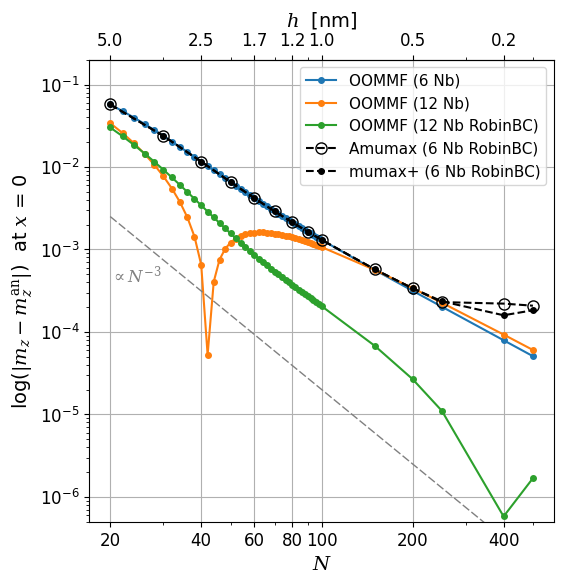

In [43]:
f, ax = plt.subplots(figsize=(6, 6))

for s in suffix_values:
    sdata = [sol for sol in solutions if sol.suffix==s]
    sdata = sorted(sdata, key=lambda x: x.n_x)
    # print(sdata)
    # print(sdata.sort(key=lambda x: x.n_x))
    mzerr = [np.abs(d.mz_interp(-L) - np.cos(theta_Boundary_MODEL)) for d in sdata]
    ns = np.array([d.n_x for d in sdata])
    z = np.polyfit(np.log(ns), np.log(mzerr), 1)
    print(s, z)
    ax.plot(ns, mzerr,
            "o-",
            alpha=1.0, ms=4,
            label=f"OOMMF ({suffix_labels[s]})")

ax.plot(amx_n_vs_error_MM[:, 0], amx_n_vs_error_MM[:, 1], '--ok', label='Amumax (6 Nb RobinBC)', ms=8, fillstyle='none')

ax.plot(mmp_n_vs_error_MM[:, 0], mmp_n_vs_error_MM[:, 1], '--ok', label='mumax+ (6 Nb RobinBC)', ms=4)

# Scaling reference line
# xN2 = np.linspace(20, 400, 200)
# ax.plot(xN2, xN2**-2)

xN3 = np.linspace(20, 500, 200)
ax.plot(xN3, np.exp(3) * xN3**-3, '--', color='grey', lw=1, dashes=[6, 2])

ax.legend(fontsize=11)
ax.set_xlabel(r'$N$')
ax.set_ylabel(r'log($|m_z - m_z^{\mathrm{an}}|$)  at $x$ = 0')
ax.set_yscale('log')
ax.set_xscale('log')
xts = [20 * i for i in range(1, 6)] + [200, 400]  # n values
ax.set_xticks([x for x in xts])
ax.set_xticklabels(['{:.0f}'.format(x) for x in xts])
ax.set_ylim(0.5e-6, 0.2)

ax.text(20., 0.4e-3, '$\propto N^{-3}$', color ='grey')

hs = [100 / n for n in xts]
ax2 = ax.secondary_xaxis('top')
ax2.set_xticks([x for x in xts])
ax2.set_xticklabels(['{:.1f}'.format(h) for h in hs])
ax2.set_xlabel(r'$h$  [nm]')

plt.grid()

# Save using Sine Gordon model:
plt.savefig('N_vs_err-mz_OOMMF_stencils_SG.pdf', bbox_inches='tight')